In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random
import pandas as pd

Using TensorFlow backend.


In [54]:
sequence_length = 1000
batch_size = 1000
epochs = 1

In [55]:
def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result

In [84]:
def get_data(train_start, train_end,
                          test_start, test_end):
    data = pd.read_csv('train.csv')
    #data = data.tag01
    data = z_norm(data)
    
    # train data
    print("Creating train data...")
    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data.ix[:, index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)    
    
        
    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    
    # test data
    print("Creating test data...")
    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    X_test = result[:, :-1]
    y_test = result[:, -1]

    
    
    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], data.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], data.shape[1]))

    return X_train, y_train, X_test, y_test

In [85]:
get_data(0, 100000, 90000, 130000)

Creating train data...
             Time     tag00     tag01     tag04     tag05    tag06     tag07  \
0       -1.731981 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
1       -1.731979 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
2       -1.731976 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
3       -1.731974 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
4       -1.731972 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
5       -1.731969 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
6       -1.731967 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
7       -1.731965 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
8       -1.731962 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
9       -1.731960 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
10      -1.731958 -5.455156 -2.426142 -0.185788 -0.098084 -0.20419 -0.205461   
11      -1.731955

In [75]:
X_train, y_train, X_test, y_test = get_data(0, 100000, 90000, 130000)

Creating train data...


IndexError: too many indices for array

In [59]:
def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 24, 'hidden2': 24, 'hidden3': 40, 'output': 1}

    model.add(LSTM(
            input_length=sequence_length - 1,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    #model.add(LSTM(
    #        layers['hidden2'],
    #        return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("Compilation Time : ", time.time() - start)
    return model

In [60]:
def run_network(model=None, data=None):
    global_start_time = time.time()

    print('\nData Loaded. Compiling...\n')

    model = build_model()

    print("Training...")
    model.fit(
            X_train, y_train,
            batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
    print("Predicting...")
    predicted = model.predict(X_test)
    print("Reshaping predicted")
    predicted = np.reshape(predicted, (predicted.size,))


    plt.figure(1)
    plt.subplot(311)
    plt.title("Actual Test Signal w/Anomalies")
    plt.plot(y_test[:len(y_test)], 'b')
    plt.subplot(312)
    plt.title("Predicted Signal")
    plt.plot(predicted[:len(y_test)], 'g')
    plt.subplot(313)
    plt.title("Squared Error")
    mse = ((y_test - predicted) ** 2)
    plt.plot(mse, 'r')
    plt.show()

    return model, y_test, predicted


Data Loaded. Compiling...



/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(999, 1), units=24)`
/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
/home/fao3864/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Compilation Time :  0.017363548278808594
Training...
Train on 94050 samples, validate on 4950 samples
Epoch 1/1
94050/94050 [==============================] - 1994s - loss: 0.0377 - val_loss: 0.0056

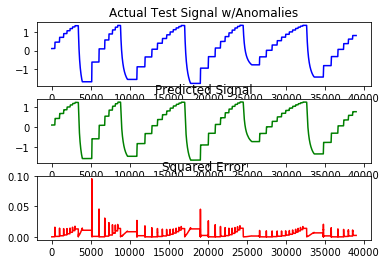

(<keras.models.Sequential at 0x7f8d510cb208>,
 array([ 0.11296216,  0.11296216,  0.11296216, ...,  0.81888736,
         0.81888736,  0.81888736]),
 array([ 0.10125564,  0.10125563,  0.10125564, ...,  0.76956308,
         0.76956308,  0.76956308], dtype=float32))

In [61]:
run_network()

In [62]:
model.save_weights('first_try.h5') 

Loading data... 
wave1 1000
wave2 1000
wave3 50
Length of Data 1000
Creating train data...
Mean of train data :  0.00171749842652
Train data shape  :  (600, 100)
Creating test data...
Mean of test data :  0.0164747512469
Test data shape  :  (400, 100)
Shape X_train (600, 99)
Shape X_test (400, 99)

Data Loaded. Compiling...



/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:123: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:123: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(99, 1), units=64)`
/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:137: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
/home/fao3864/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Compilation Time :  0.017934083938598633
Training...
Train on 570 samples, validate on 30 samples
Epoch 1/1
570/570 [==============================] - 25s - loss: 0.4828 - val_loss: 0.0908
Predicting...
Reshaping predicted


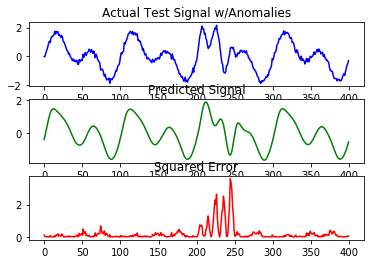

Training duration (s) :  36.35248279571533


(<keras.models.Sequential at 0x7f9a753e3470>,
 array([-0.03234027, -0.01299899,  0.17696021,  0.37163726,  0.48932391,
         0.72637937,  0.93782884,  1.04655172,  0.94511579,  1.30762295,
         1.3353632 ,  1.4208764 ,  1.43421399,  1.52626842,  1.74629737,
         1.54415277,  1.72848576,  1.69945324,  1.72272295,  1.44364595,
         1.52105484,  1.40199673,  1.30996643,  1.44608385,  1.30062824,
         1.02082758,  0.9835917 ,  0.86424928,  0.68650609,  0.53685679,
         0.3906353 ,  0.35000351,  0.13917691,  0.19648548, -0.00479065,
        -0.08431134, -0.17570223, -0.30625616, -0.19783829, -0.34507165,
        -0.2823547 , -0.39815058, -0.32381145, -0.29085709, -0.55892524,
        -0.56973171, -0.23815655, -0.39330687, -0.29637955, -0.23046068,
        -0.29481457,  0.13347121, -0.06621533,  0.12090256,  0.25305059,
         0.05574722,  0.20679014,  0.270261  ,  0.33594441,  0.48777563,
         0.39347172,  0.27181453,  0.46373086,  0.31536627,  0.19971596,
     

In [8]:
""" Inspired by example from
https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent
Uses the TensorFlow backend
The basic idea is to detect anomalies in a time-series.
"""
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random

np.random.seed(1234)

# Global hyper-parameters
sequence_length = 100
random_data_dup = 10  # each sample randomly duplicated between 0 and 9 times, see dropin function
epochs = 1
batch_size = 50


def dropin(X, y):
    """ The name suggests the inverse of dropout, i.e. adding more samples. See Data Augmentation section at
    http://simaaron.github.io/Estimating-rainfall-from-weather-radar-readings-using-recurrent-neural-networks/
    :param X: Each row is a training sequence
    :param y: Tne target we train and will later predict
    :return: new augmented X, y
    """
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    X_hat = []
    y_hat = []
    for i in range(0, len(X)):
        for j in range(0, np.random.random_integers(0, random_data_dup)):
            X_hat.append(X[i, :])
            y_hat.append(y[i])
    return np.asarray(X_hat), np.asarray(y_hat)


def gen_wave():
    """ Generate a synthetic wave by adding up a few sine waves and some noise
    :return: the final wave
    """
    t = np.arange(0.0, 10.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.1, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = round(0.8 * len(t))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    return wave1 + wave2


def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean


def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    print("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print("Mean of train data : ", result_mean)
    print("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    #X_train, y_train = dropin(X_train, y_train)

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print("Mean of test data : ", result_mean)
    print("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test


def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(
            input_length=sequence_length - 1,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("Compilation Time : ", time.time() - start)
    return model


def run_network(model=None, data=None):
    global_start_time = time.time()

    if data is None:
        print('Loading data... ')
        # train on first 700 samples and test on next 300 samples (has anomaly)
        X_train, y_train, X_test, y_test = get_split_prep_data(0, 700, 500, 1000)
    else:
        X_train, y_train, X_test, y_test = data

    print('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0

    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration (s) : ', time.time() - global_start_time)

    return model, y_test, predicted


run_network()

In [92]:
import pandas as pd
from random import random

data = pd.read_csv('train.csv')
data = data[:50000]
data = z_norm(data)

import numpy as np

def _load_data(data, n_prev = 1000):
    """
    data should be pd.DataFrame()
    """
    print("loading data")
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)
    
    return alsX, alsY

def train_test_split(df, test_size=0.1):
    """
    This just splits data to training and testing parts
    """
    print("split data")
    ntrn = round(len(df) * (1 - test_size))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM

in_out_neurons = 18
hidden_neurons = 50

print("Creating model")
model = Sequential()
model.add(LSTM(hidden_neurons, input_dim=in_out_neurons, return_sequences=False))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")

(X_train, y_train), (X_test, y_test) = train_test_split(data)  # retrieve data
print("Fitting")
model.fit(X_train, y_train, batch_size=1000, nb_epoch=1, validation_split=0.05)

predicted = model.predict(X_test)
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))

# and maybe plot it
pd.DataFrame(predicted).to_csv("predicted.csv")
pd.DataFrame(y_test).to_csv("test_data.csv")

Creating model


/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/fao3864/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, return_sequences=False, input_shape=(None, 18))`


split data
loading data
loading data
Fitting


/home/fao3864/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 41800 samples, validate on 2200 samples
Epoch 1/1
41800/41800 [==============================] - 765s - loss: 0.4539 - val_loss: 0.4286

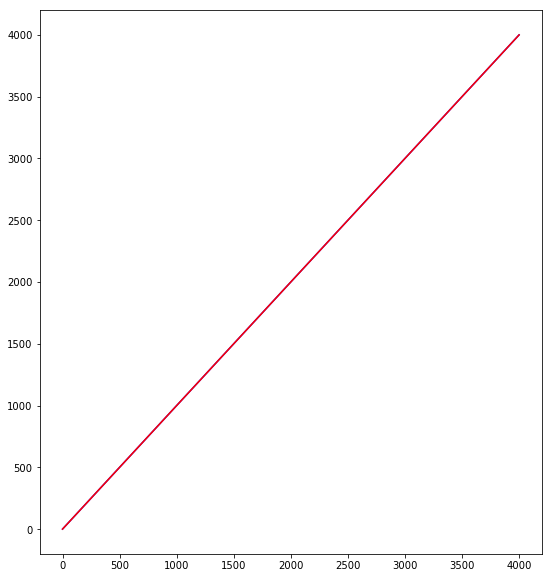

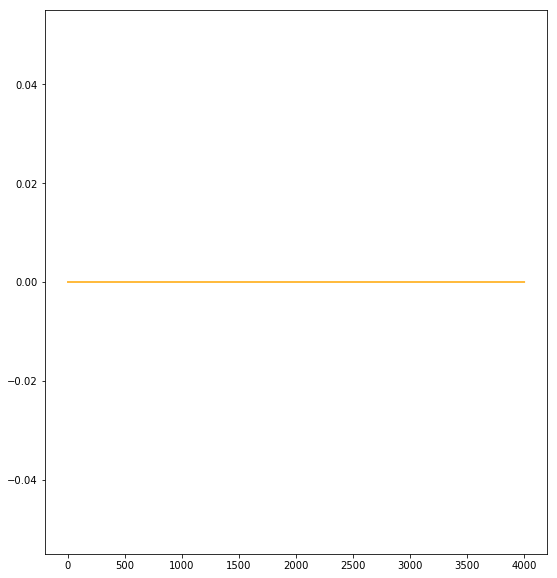

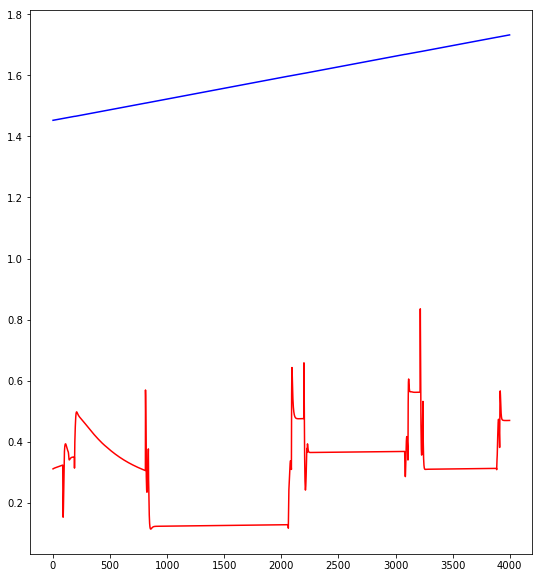

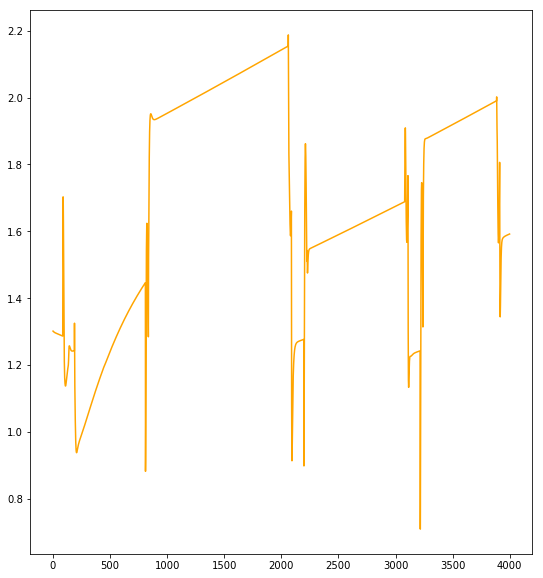

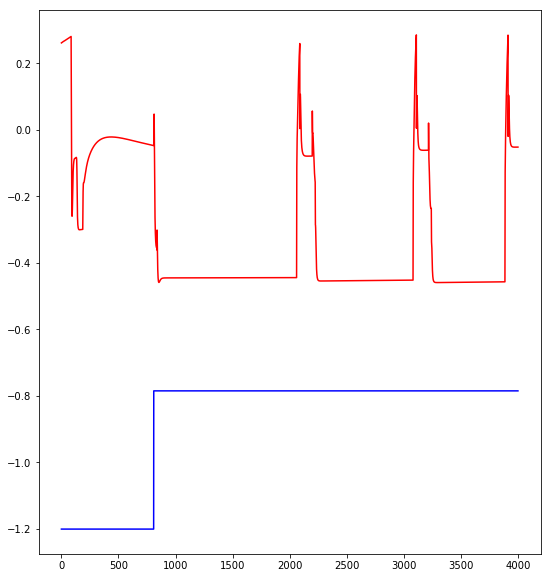

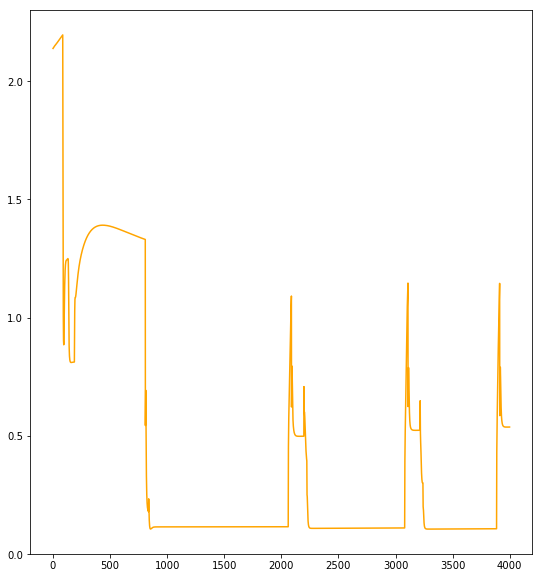

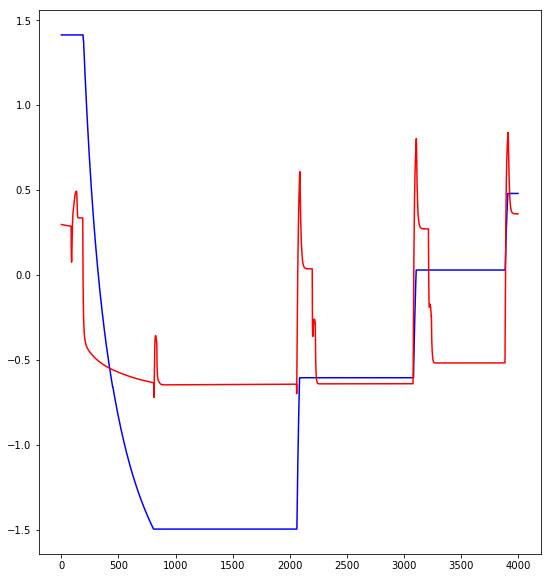

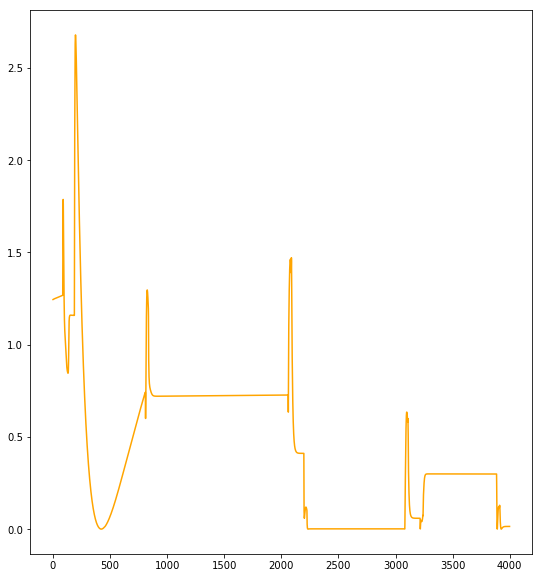

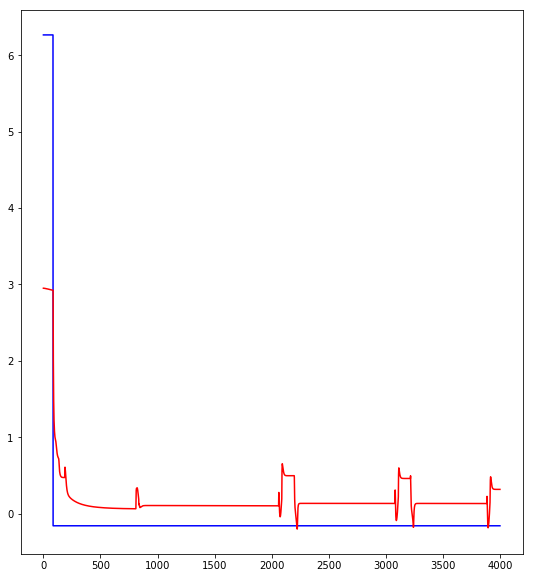

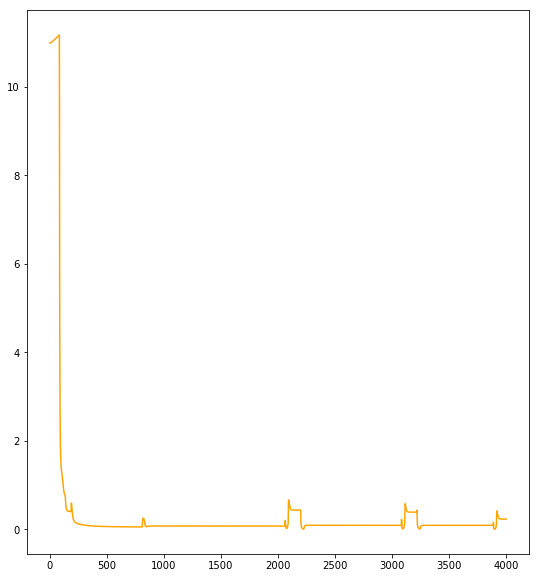

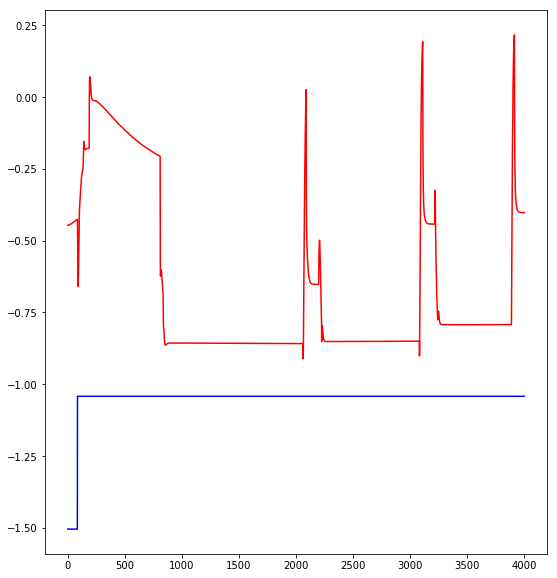

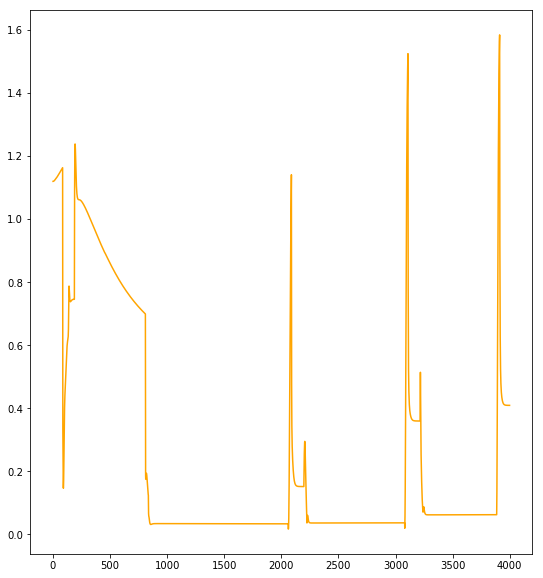

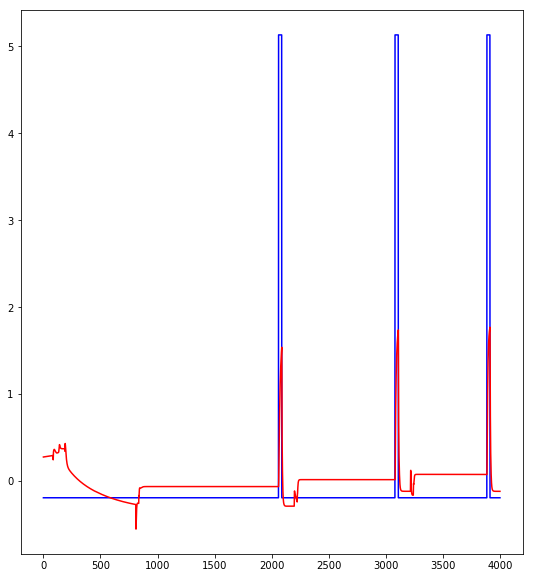

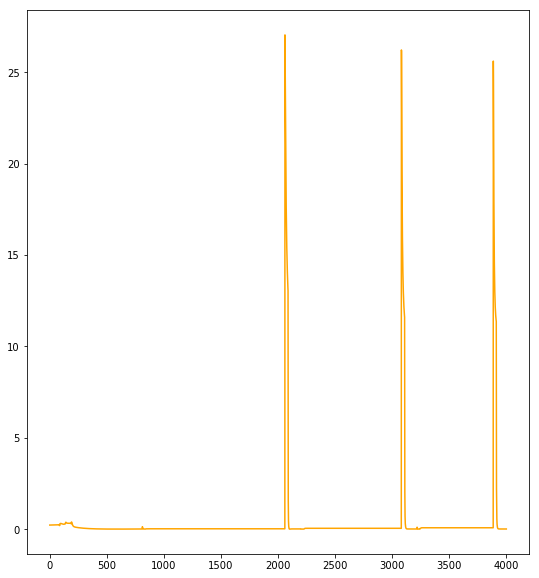

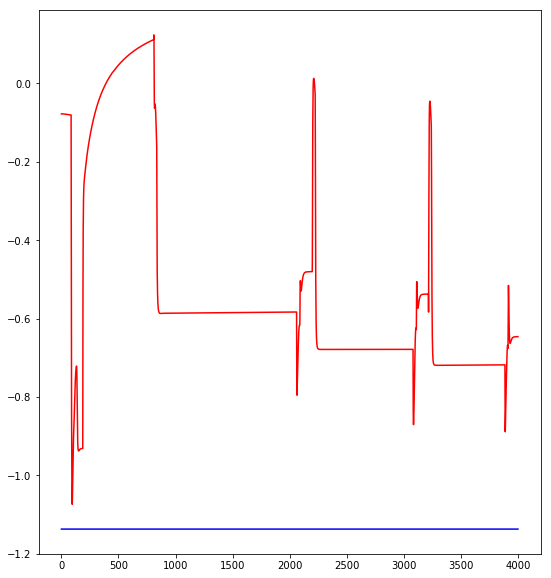

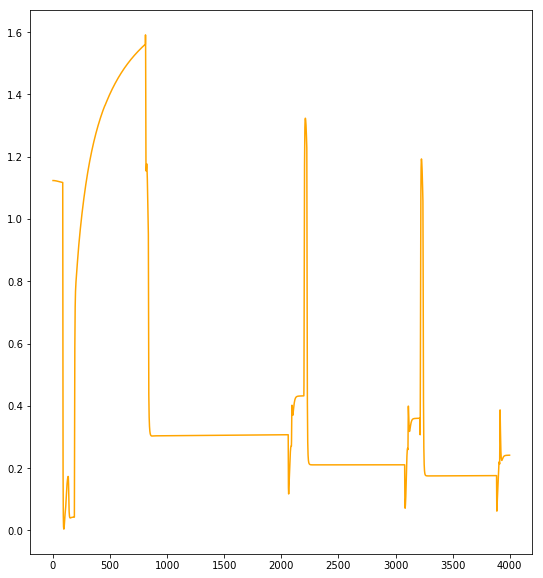

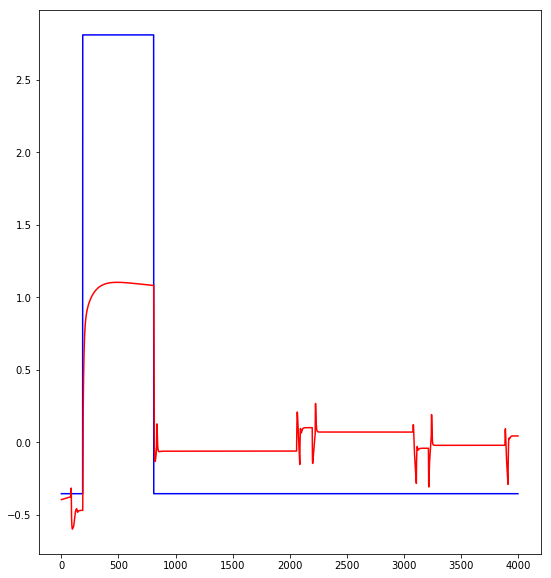

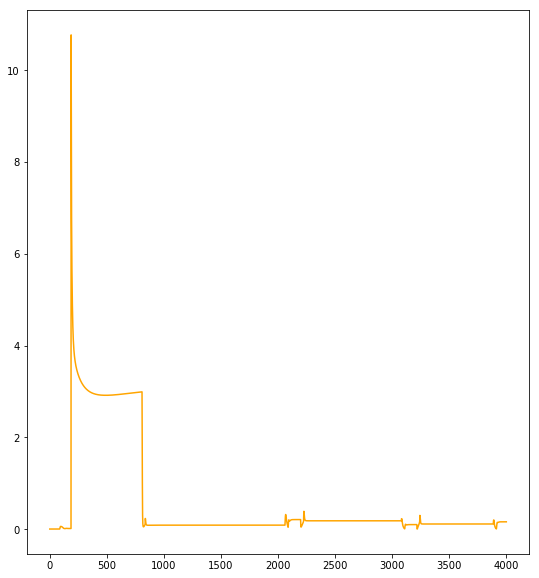

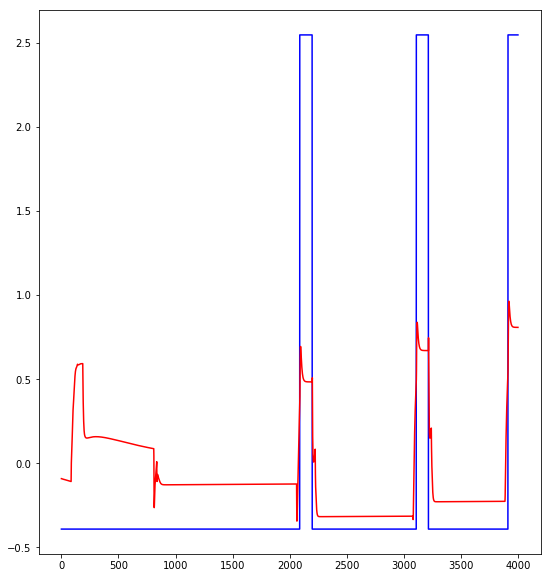

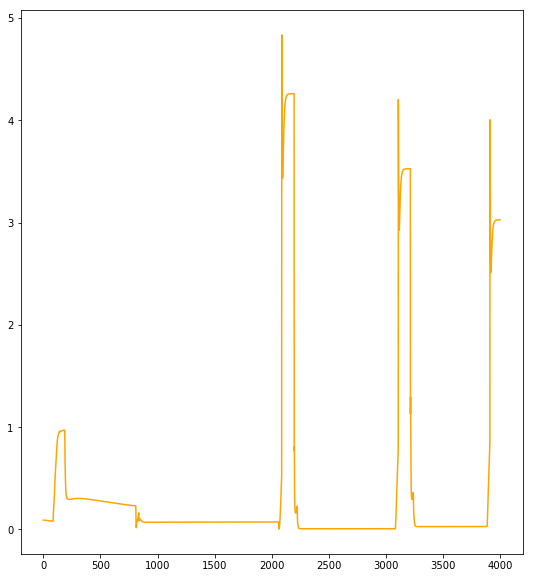

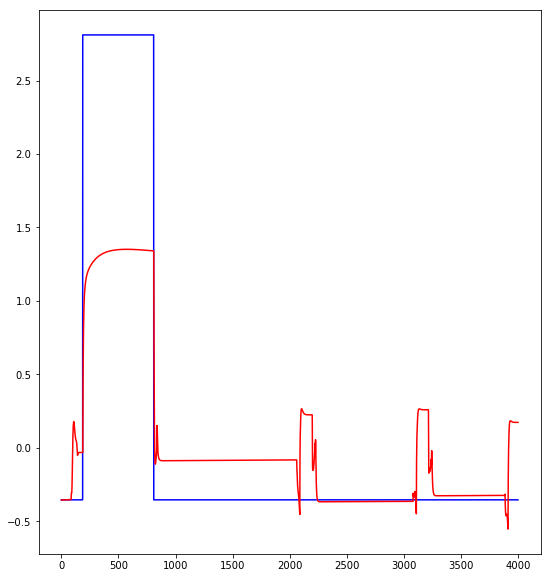

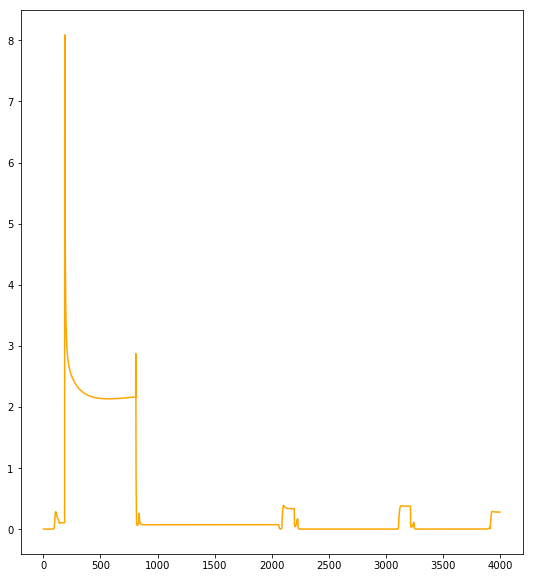

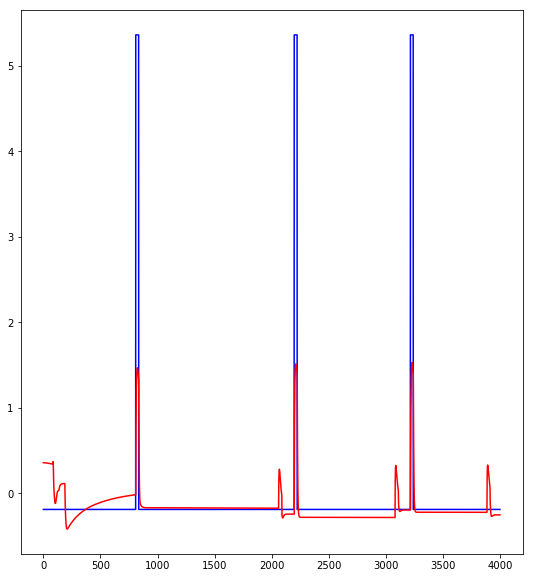

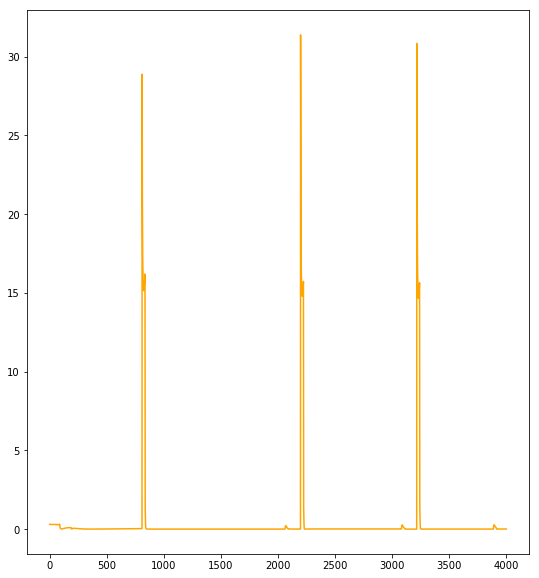

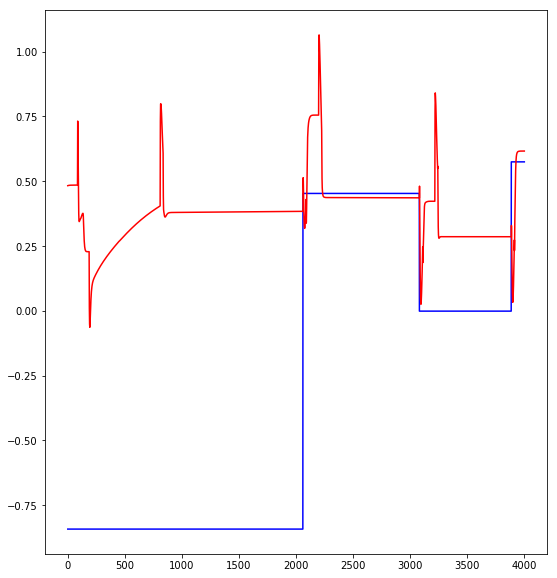

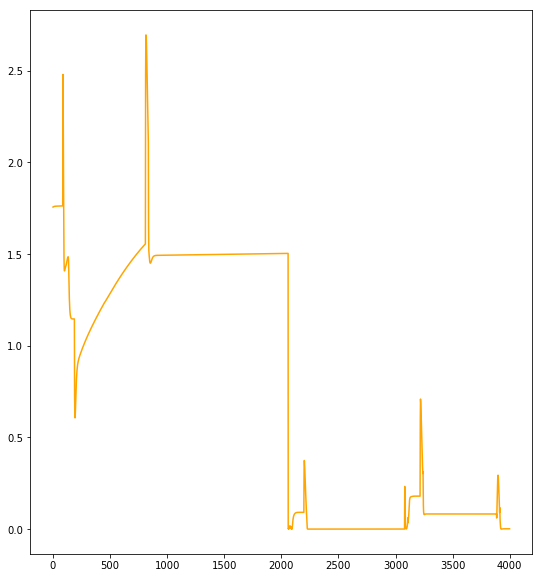

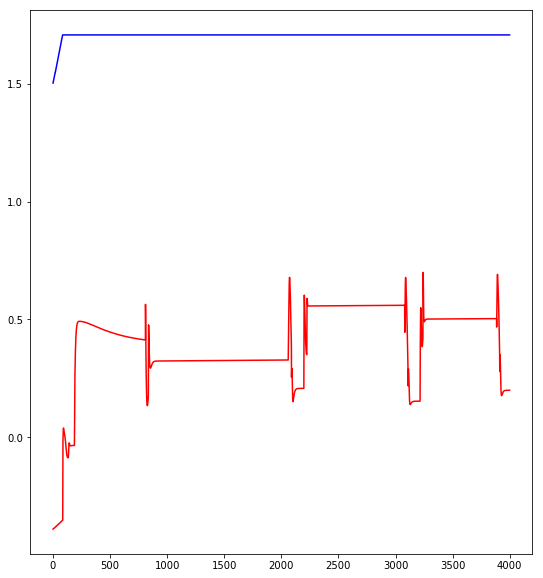

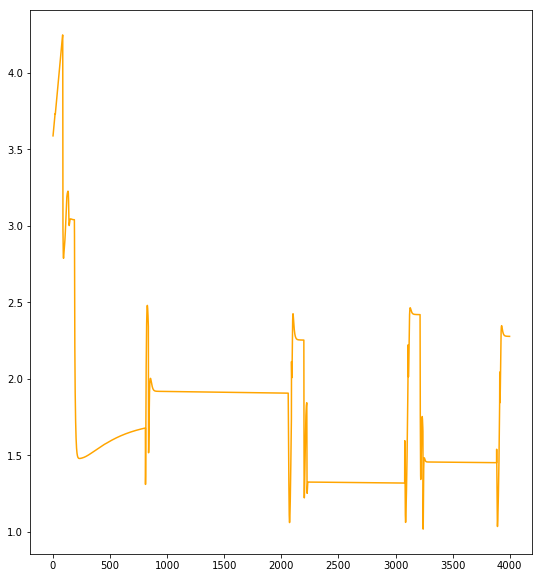

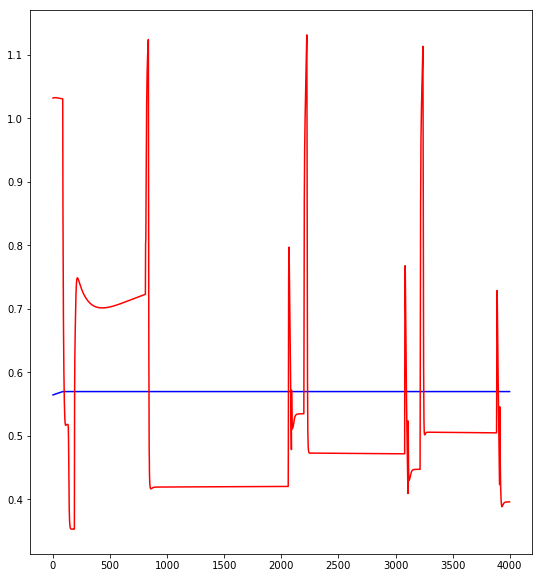

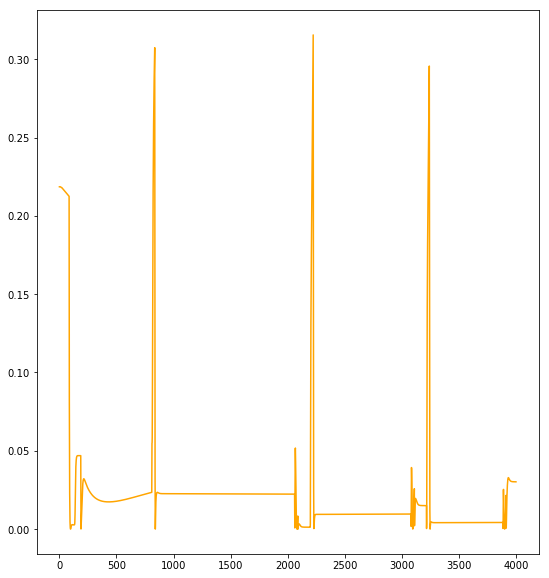

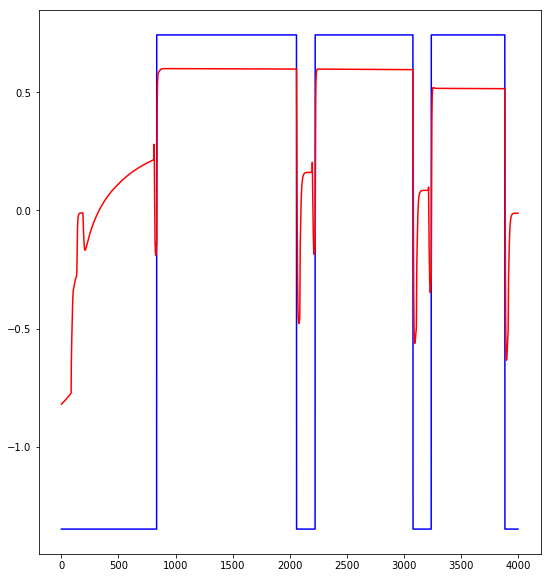

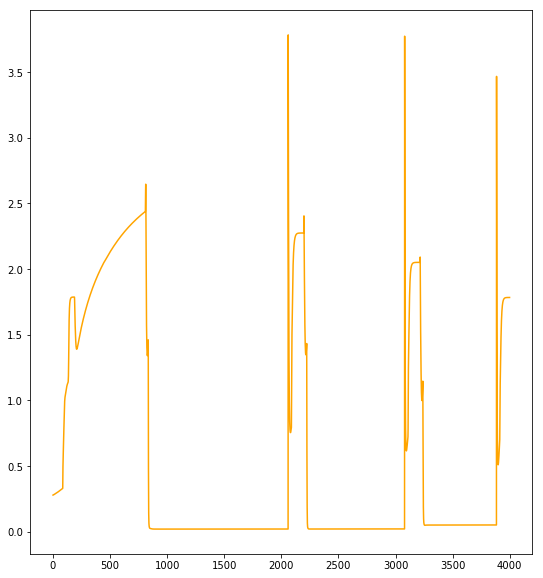

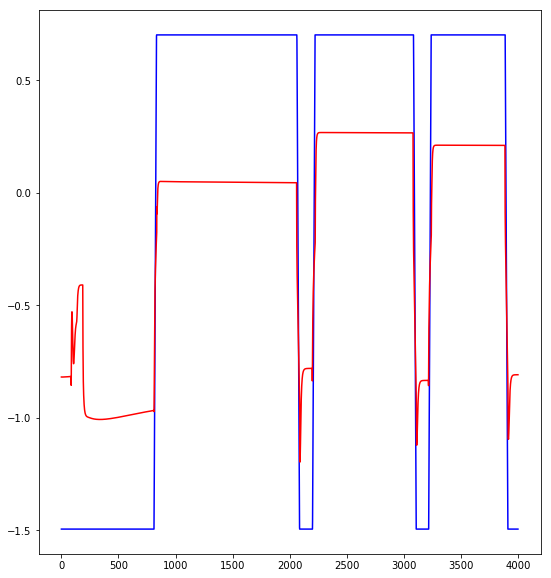

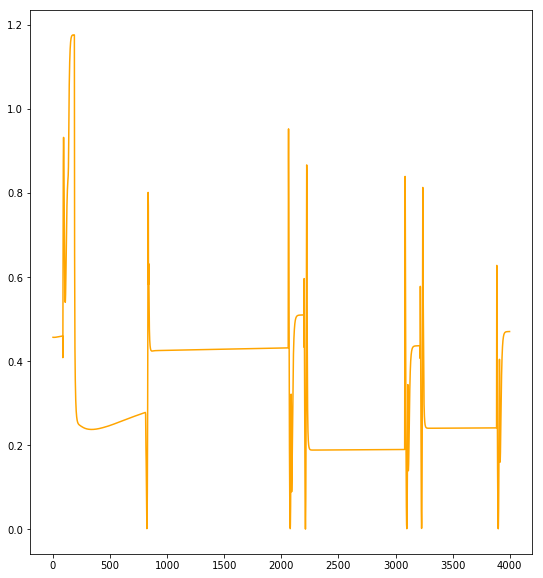

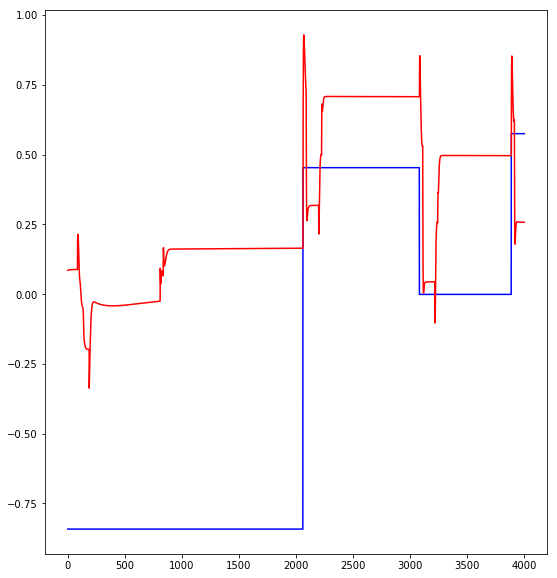

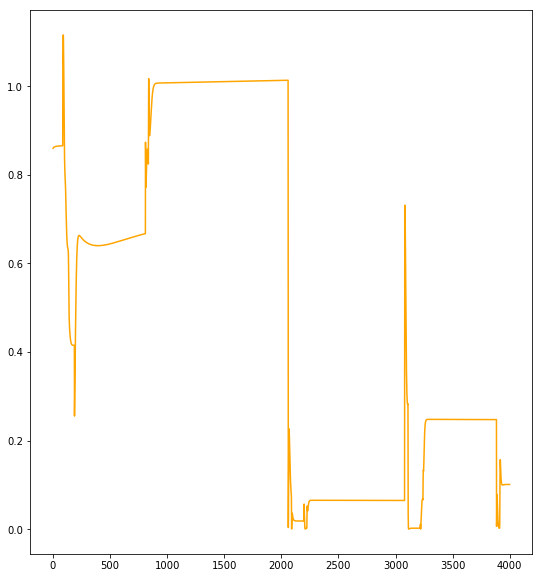

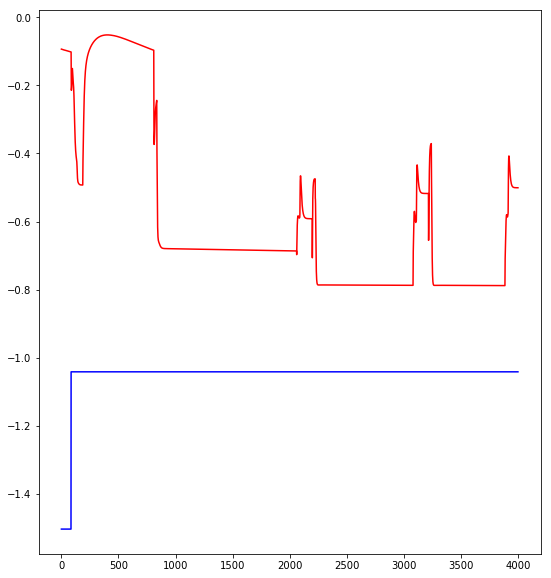

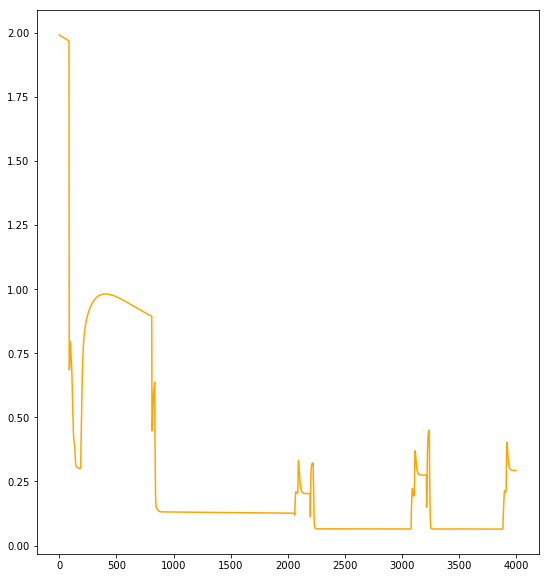

In [98]:
pred = pd.read_csv('predicted.csv')
real = pd.read_csv('test_data.csv')
mse = ((pred - real) ** 2)

for i in pred.columns:
    plt.figure(figsize=(9, 10))
    plt.plot(real.ix[:, i], c='blue')
    plt.plot(pred.ix[:, i], c='red')
    plt.figure(figsize=(9, 10))
    plt.plot(mse.ix[:, i], c='orange')
    plt.show()